In [0]:
import os
import torch
from torch.nn import functional as F
import itertools
import dataset_loader
import numpy as np
from matplotlib import pyplot as plt

In [0]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"

--2019-12-13 21:06:32--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  4.43MB/s    in 4.0s    

2019-12-13 21:06:37 (3.89 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

In [0]:
def create_batch(data, index, batch_size):
  if index + batch_size > len(data[0]): batch_size = len(data[0]) - index - 1
  return (torch.cat(
      [
          # we reshape the image tensor so it has dimension (1, 784)
          torch.from_numpy(image).reshape(1, -1)
          for image in data[0][index:index + batch_size]
      ],
      # we want to concatenate on the batch dimension
      dim=0),

      torch.tensor(data[1][index:index + batch_size])
  )

## Part 2: Variational Auto-Encoder¶

To build a new Variational Auto-Encoder, you need two networks:

- An encoder that will take as input an image and compute the parameters of list of Normal distributions
- A decoder that will take a sample from each Normal distribution and will output an image

For simplicity we will assume that:

- each network as a single hidden layer of size 100
- the latent space contains only 2 points

To understand exactly what a VAE is, you can:

- check the slides of Michèle Sebag
- check this tutorial: https://arxiv.org/abs/1606.05908

## 1.2. Encoder

- Compute an hidden representation: z=relu(W1x+b1)
- Compute the means of the normal distributions: mu=W2x+b2
- Compute the log variance of the normal distributions: log_sigma_squared=W3x+b3

In [0]:
class Encoder(torch.nn.Module):
  def __init__(self, input_dim, hdim, normal_dim):
    super().__init__()
    self.z_proj = torch.nn.Linear(input_dim, hdim)
    self.mu = torch.nn.Linear(hdim, normal_dim)
    self.log_sigma_squared = torch.nn.Linear(hdim, normal_dim)

  def forward(self, batch):
    z = self.z_proj(batch)
    z = torch.relu(z)
    mu = self.mu(z)
    log_sigma_squared = self.log_sigma_squared(z)

    e = torch.normal(0, 1., mu.shape)
    z = mu + e * torch.sqrt(torch.exp(log_sigma_squared))

    return z, mu, log_sigma_squared

## 1.2. Decoder

This a simple MLP, nothing new here!

In [0]:
class Decoder(torch.nn.Module):
  def __init__(self, input_dim, hdim, output_dim):
    super().__init__()
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, hdim),
        torch.nn.ReLU(),
        torch.nn.Linear(hdim,output_dim)
    )

  def forward(self, batch):
    return self.decoder(batch)

## 1.3. Training loss

To compute the training loss, you must compute two terms:

- a Monte-Carlo estimation of the reconstruction loss
- the KL divergence between the distributions computed by the encoder and the prior

To sample values, you can use the reparameterization trick as follows:

In [0]:
loss_builder = torch.nn.BCEWithLogitsLoss(reduction="sum")

In [0]:
def loss_function(gen_x, x, mu, log_sigma_squared):
    BCE = loss_builder(gen_x, x)

    KLD = -0.5 * torch.sum(1 + log_sigma_squared - mu.pow(2) - log_sigma_squared.exp())

    return BCE + KLD

In [0]:
enc = Encoder(
    784,  # dimension of image
    100,  # size of hidden layer
    2     # size of latent space
)

In [0]:
dec = Decoder(
    2,    # size of latent space
    100,  # size of hidden layer
    784   # dimension of image
)

In [0]:
optimizer = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))


## 1.4. Recomended hyper parameters

- Optimizer: Adam
- N. epochs: 50
- Use gradient clipping!
- Large batch size, e.g. 128

In [0]:
batch_size = 128
n_epochs = 50

for epoch in range(n_epochs):
  enc.train()
  dec.train()
  for i in range(0,len(train_data[0]),batch_size):
    batch = create_batch(train_data, i, batch_size)
    x = batch[0]

    z, mu, log_sigma_squared = enc(x)
    gen_x = dec(z)

    loss = loss_function(gen_x, x, mu, log_sigma_squared)

    enc.zero_grad()
    dec.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(itertools.chain(enc.parameters(), dec.parameters()), 5.)  # clip gradient if its norm exceed 5
    optimizer.step()

  print(loss.item())

13792.0166015625
13214.0400390625
12944.67578125
12777.568359375
12652.83984375
12562.9423828125
12560.587890625
12394.060546875
12262.1806640625
12236.0400390625
12151.5625
12115.5341796875
12028.2646484375
12007.8466796875
11961.25390625
11985.5048828125
11911.79296875
11897.931640625
11862.9208984375
11899.189453125
11887.84375
11820.037109375
11779.3291015625
11795.3798828125
11878.568359375
11739.73828125
11786.4169921875
11776.1435546875
11760.7880859375
11693.4892578125
11772.8154296875
11733.8955078125
11705.5322265625
11748.7197265625
11643.8720703125
11667.015625
11644.6748046875
11668.18359375
11682.90234375
11672.6552734375
11624.962890625
11609.34765625
11674.0966796875
11655.072265625
11631.7880859375
11601.98828125
11654.8828125
11626.3134765625
11584.0361328125
11644.9521484375


## 1.5. Generate new images

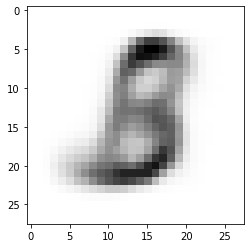

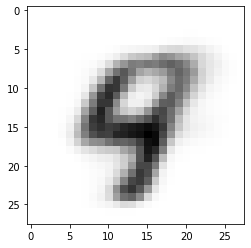

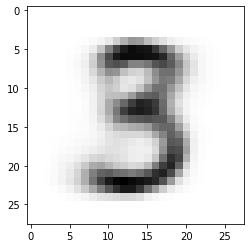

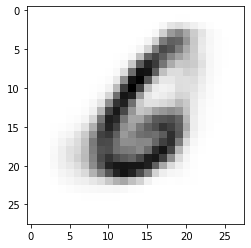

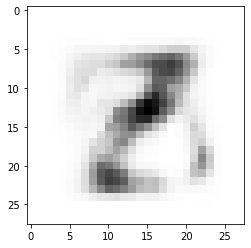

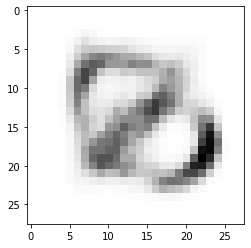

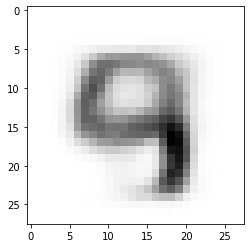

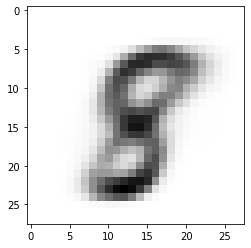

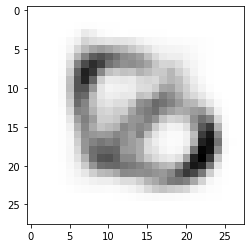

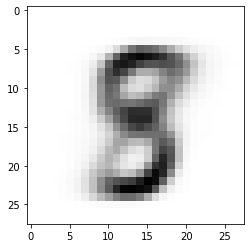

In [0]:
e = torch.normal(0, 1., (10, 2))
images = dec(e).sigmoid()

for i in range(10):
    picture = images[i].clone().detach().numpy()
    plt.imshow(picture.reshape(28,28), cmap='Greys')
    plt.show()

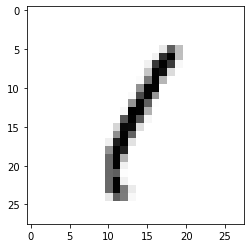

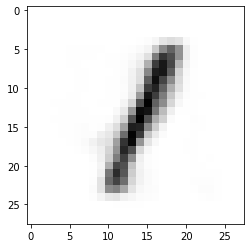

In [0]:
batch = create_batch(dev_data,15,1)
x = batch[0]

plt.imshow(x.reshape(28,28), cmap='Greys')
plt.show()

e, m, s = enc(x)
x_gen = dec(e).sigmoid()

plt.imshow(x_gen.detach().numpy().reshape(28,28), cmap='Greys')
plt.show()